<a href="https://colab.research.google.com/github/fkeppeler/Coursera_Capstone/blob/master/Clash_of_Neighbourhoods_Capstone_DataScienceIBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#!pip install geojson
#!pip install folium
#!pip install Shapely

import folium
import json
import urllib
import requests
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import colors
from matplotlib import cm
from geopy.geocoders import Nominatim
from shapely.geometry import Point, Polygon




In [9]:
url ='https://ckan0.cf.opendata.inter.prod-toronto.ca/datastore/dump/a083c865-6d60-4d1d-b6c6-b0c8a85f9c15'
neighbourhoods = pd.read_csv(url,header=0)

neighbourhoods.sort_values(by=['AREA_LONG_CODE'],inplace=True)
neighbourhoods['AREA_LONG_CODE']=neighbourhoods.AREA_LONG_CODE.astype(int)
neighbourhoods.rename (columns={'AREA_LONG_CODE':'Neighbourhood Id'},inplace=True)
neighbourhoods=neighbourhoods[['Neighbourhood Id','LONGITUDE','LATITUDE','geometry']]

neighbourhoods.head()


,Neighbourhood Id,LONGITUDE,LATITUDE,geometry
63,1,-79.596356,43.716180,"{""type"": ""Polygon"", ""coordinates"": [[[-79.5523..."
20,2,-79.587259,43.746868,"{""type"": ""Polygon"", ""coordinates"": [[[-79.6033..."
56,3,-79.563491,43.737988,"{""type"": ""Polygon"", ""coordinates"": [[[-79.5775..."
40,4,-79.566228,43.723725,"{""type"": ""Polygon"", ""coordinates"": [[[-79.5551..."
112,5,-79.548983,43.721519,"{""type"": ""Polygon"", ""coordinates"": [[[-79.5551..."


In [10]:
# Create URL to Excel file (alternatively this can be a filepath)
url = 'https://ckan0.cf.opendata.inter.prod-toronto.ca/dataset/15a37448-b27e-44d2-9c2e-52e148c8894f/resource/335e3407-d3ca-422a-bfac-e3807cfbe0d5/download/wellbeing-toronto-demographics.xlsx'

# Load the first sheet of the Excel file into a data frame
socio_economic = pd.read_excel(url, sheet_name=1,header=1)
socio_economic.head()

,Neighbourhood,Neighbourhood Id,Total Area,Total Population,Pop - Males,Pop - Females,Pop 0 - 4 years,Pop 5 - 9 years,Pop 10 - 14 years,Pop 15 -19 years,Pop 20 - 24 years,Pop 25 - 29 years,Pop 30 - 34 years,Pop 35 - 39 years,Pop 40 - 44 years,Pop 45 - 49 years,Pop 50 - 54 years,Pop 55 - 59 years,Pop 60 - 64 years,Pop 65 - 69 years,Pop 70 - 74 years,Pop 75 - 79 years,Pop 80 - 84 years,Pop 85 years and over,Pop 6-12 years,Visible Minority Category,Chinese,South Asian,Black,Filipino,Latin American,Southeast Asian,Arab,West Asian,Korean,Japanese,Other Visible Minority,Multiple Visible Minority,Not a Visible Minority,Aboriginal,...,Language - Portuguese,Language - Russian,Language - Spanish,Language - Tagalog,Language - Tamil,Language - Urdu,Mobility Category,Non-Movers,Movers,Recent Immigrants Category,Recent Immigrants,Southern Asia,South East Asia,Eastern Asia,West Asia/Middle East,Africa,Europe,Caribbean/Central/S. America,Labour Force Category,In Labour Force,Unemployed,Not in Labour Force,Less than grade 9,With College Certificate/Diploma,With Bachelor Degree or Higher,Seniors Living Alone,Total Tenants,High Shelter Costs,Owned Dwellings,Rented Dwellings,Home Repairs Needed,Tenant Average Rent,Low Income Families,Low Income Singles,Low Income Children,Family Income Category,Average Family Income,Household Income Category,Pre-Tax Household Income,After-Tax Household Income
0,West Humber-Clairville,1,30.09,32265,16295,15960,2005,2135,2325,2180,2565,2465,2400,2440,2595,2375,1955,1800,1415,1150,1015,715,465,305,3126,31380,795,12740,5495,1385,1340,465,250,155,130,30,1055,585,6930,65,...,20,35,945,525,525,625,29355,16920,12430,3825,3825,2355,190,70,35,425,105,580,24895,16535,1165,8385,1520,3050,370,395,2450,2955,6505,2460,365,850,7720,725,643,7720,67240,8960,63415,63977
1,Mount Olive-Silverstone-Jamestown,2,4.60,32130,15900,16230,2680,2680,2685,2285,2410,2590,2675,2605,2450,2130,1700,1495,1200,910,775,500,270,145,3782,32105,600,12920,7225,710,1325,625,1180,1040,65,75,1250,365,4735,50,...,70,45,900,335,1275,905,29410,13965,15445,7125,7125,4355,115,110,890,755,45,805,24070,15875,1570,8175,1705,2975,400,400,4815,3600,4440,4820,980,875,7715,1177,1206,7720,52745,9265,48145,49601
2,Thistletown-Beaumond Heights,3,3.40,9925,4900,5035,615,625,645,630,655,650,650,730,790,735,590,520,420,400,425,385,255,190,893,9755,75,2430,1450,125,475,75,110,280,65,0,100,60,4505,50,...,70,20,325,40,290,210,9150,6460,2695,950,950,525,20,10,145,130,40,60,7905,4895,310,3005,500,785,90,265,1090,1040,2065,1085,185,875,2520,305,161,2520,71300,3150,55030,54910
3,Rexdale-Kipling,4,2.50,10725,5205,5525,580,645,665,640,630,600,705,815,840,810,720,600,505,435,460,435,345,285,919,10445,145,1515,860,250,760,200,75,210,25,115,100,100,6075,65,...,55,40,490,50,70,170,9865,5865,4005,865,860,380,65,0,105,60,100,125,8560,5400,415,3170,530,735,55,490,1750,1350,2125,1750,300,835,2780,653,135,2775,65215,3880,52430,53779
4,Elms-Old Rexdale,5,2.90,9440,4615,4820,725,700,745,655,615,645,640,735,740,750,585,505,385,310,275,205,150,55,1020,9435,165,965,2475,395,745,185,140,245,75,10,150,145,3730,45,...,40,50,575,270,80,295,8715,5195,3515,925,925,275,90,40,75,285,35,125,7265,4610,360,2655,560,705,60,130,1285,1040,1845,1290,320,895,2560,255,328,2555,56515,3130,53780,55054


In [11]:
neighbourhoods_merged=pd.merge (neighbourhoods,socio_economic,how='inner',on='Neighbourhood Id')
neighbourhoods_merged.rename(columns={'   Average Family Income':'Avg_Family_Income'}, 
                 inplace=True)

neighbourhoods_merged['Pop_density']=np.log(neighbourhoods_merged['Total Population']/neighbourhoods_merged['Total Area']) #Calculate population density
neighbourhoods_merged['Perc_young_ind']=neighbourhoods_merged.iloc[:,11:19].sum(axis=1)/neighbourhoods_merged['Total Population'] #Percentage of young individuals in the population
neighbourhoods_merged['Avg_Family_Income']=np.sqrt(neighbourhoods_merged['Avg_Family_Income'])
neighbourhoods_merged= neighbourhoods_merged[['Avg_Family_Income','Pop_density','Perc_young_ind','Neighbourhood','geometry']]
neighbourhoods_merged.head(3)

,Avg_Family_Income,Pop_density,Perc_young_ind,Neighbourhood,geometry
0,259.306768,6.977545,0.599566,West Humber-Clairville,"{""type"": ""Polygon"", ""coordinates"": [[[-79.5523..."
1,229.662796,8.851489,0.617180,Mount Olive-Silverstone-Jamestown,"{""type"": ""Polygon"", ""coordinates"": [[[-79.6033..."
2,267.020598,7.979037,0.552645,Thistletown-Beaumond Heights,"{""type"": ""Polygon"", ""coordinates"": [[[-79.5775..."


In [12]:
url = 'https://ckan0.cf.opendata.inter.prod-toronto.ca/datastore/dump/02ef7447-54d9-4aa7-b76d-8ef8138ac546'
schools = pd.read_csv(url,header=0)
schools.head()

,_id,OBJECTID,GEO_ID,NAME,SCHOOL_LEVEL,SCHOOL_TYPE,BOARD_NAME,SOURCE_ADDRESS,SCHOOL_TYPE_DESC,ADDRESS_POINT_ID,ADDRESS_NUMBER,LINEAR_NAME_FULL,ADDRESS_FULL,POSTAL_CODE,MUNICIPALITY,CITY,PLACE_NAME,GENERAL_USE_CODE,CENTRELINE_ID,LO_NUM,LO_NUM_SUF,HI_NUM,HI_NUM_SUF,LINEAR_NAME_ID,X,Y,LATITUDE,LONGITUDE,geometry
0,7735,1,7963754,Avondale Public School,NaN,EP,Toronto District School Board,25 Bunty Lane,English Public,7963754,25,Bunty Lane,25 Bunty Lane,M2K 1W4,North York,Toronto,Bayview Middle School,102001,7963734,25,NaN,NaN,NaN,5064,314026.623,4848287.934,43.776502,-79.385190,"{""type"": ""Point"", ""coordinates"": [-79.38518674..."
1,7736,2,7315504,Avondale Secondary Alternative School,NaN,EP,Toronto District School Board,24 Silverview Dr,English Public,7315504,24,Silverview Dr,24 Silverview Dr,M2M 2B3,North York,Toronto,Griffin Centre,102001,7315505,24,NaN,NaN,NaN,6720,311879.691,4849375.563,43.786315,-79.411846,"{""type"": ""Point"", ""coordinates"": [-79.41184315..."
2,7737,3,20258267,AYJ Global Academy,NaN,PR,NaN,4 Lansing Sq,Priv,20258267,4,Lansing Sq,4 Lansing Sq,M2J 5A2,North York,Toronto,NaN,104008,438287,4,NaN,NaN,NaN,6007,318854.727,4848028.516,43.774091,-79.325220,"{""type"": ""Point"", ""coordinates"": [-79.32521641..."
3,7738,4,7102999,Bais Brucha School,NaN,PR,NaN,3077 Bathurst St,Priv,7102999,3077,Bathurst St,3077 Bathurst St,M6A 1Z9,North York,Toronto,NaN,104008,7102975,3077,NaN,NaN,NaN,436,310459.388,4841999.775,43.719936,-79.429570,"{""type"": ""Point"", ""coordinates"": [-79.42956699..."
4,7739,5,9171677,Bais Chaya Mushka Elementary School,NaN,PR,NaN,4375 Chesswood Dr,Priv,9171677,4375,Chesswood Dr,4375 Chesswood Dr,M3J 2C2,North York,Toronto,NaN,115001,9171675,4375,NaN,NaN,NaN,5187,306600.741,4846528.168,43.760717,-79.477445,"{""type"": ""Point"", ""coordinates"": [-79.47744198..."


In [13]:
neigh_school = []

for i in range(0,schools.shape[0]):
  lon, lat = schools.iloc [i,[27,26]]
  point_temp= Point(lon, lat)
  test= False
  k=0
  while test == False:
    coord_raw = eval (neighbourhoods_merged['geometry'][k]) #convert to dict
    coord=coord_raw.get("coordinates") 
    coord=tuple(coord[0]) #convert to tuple and extract only the coordinates
    poly=Polygon(coord) #create polygon
    if point_temp.within(poly) == True:
      neigh_school.append (neighbourhoods_merged['Neighbourhood'][k])
      test=True
    else:
      test=False
      k += 1
      if k > 99:
        neigh_school.append (None)
        test= True


schools['Neighbourhood'] = neigh_school
schools= schools[schools['Neighbourhood'].notna()] #remove NAs
schools.head()

,_id,OBJECTID,GEO_ID,NAME,SCHOOL_LEVEL,SCHOOL_TYPE,BOARD_NAME,SOURCE_ADDRESS,SCHOOL_TYPE_DESC,ADDRESS_POINT_ID,ADDRESS_NUMBER,LINEAR_NAME_FULL,ADDRESS_FULL,POSTAL_CODE,MUNICIPALITY,CITY,PLACE_NAME,GENERAL_USE_CODE,CENTRELINE_ID,LO_NUM,LO_NUM_SUF,HI_NUM,HI_NUM_SUF,LINEAR_NAME_ID,X,Y,LATITUDE,LONGITUDE,geometry,Neighbourhood
0,7735,1,7963754,Avondale Public School,NaN,EP,Toronto District School Board,25 Bunty Lane,English Public,7963754,25,Bunty Lane,25 Bunty Lane,M2K 1W4,North York,Toronto,Bayview Middle School,102001,7963734,25,NaN,NaN,NaN,5064,314026.623,4848287.934,43.776502,-79.385190,"{""type"": ""Point"", ""coordinates"": [-79.38518674...",Bayview Village
1,7736,2,7315504,Avondale Secondary Alternative School,NaN,EP,Toronto District School Board,24 Silverview Dr,English Public,7315504,24,Silverview Dr,24 Silverview Dr,M2M 2B3,North York,Toronto,Griffin Centre,102001,7315505,24,NaN,NaN,NaN,6720,311879.691,4849375.563,43.786315,-79.411846,"{""type"": ""Point"", ""coordinates"": [-79.41184315...",Newtonbrook East
2,7737,3,20258267,AYJ Global Academy,NaN,PR,NaN,4 Lansing Sq,Priv,20258267,4,Lansing Sq,4 Lansing Sq,M2J 5A2,North York,Toronto,NaN,104008,438287,4,NaN,NaN,NaN,6007,318854.727,4848028.516,43.774091,-79.325220,"{""type"": ""Point"", ""coordinates"": [-79.32521641...",Henry Farm
3,7738,4,7102999,Bais Brucha School,NaN,PR,NaN,3077 Bathurst St,Priv,7102999,3077,Bathurst St,3077 Bathurst St,M6A 1Z9,North York,Toronto,NaN,104008,7102975,3077,NaN,NaN,NaN,436,310459.388,4841999.775,43.719936,-79.429570,"{""type"": ""Point"", ""coordinates"": [-79.42956699...",Bedford Park-Nortown
4,7739,5,9171677,Bais Chaya Mushka Elementary School,NaN,PR,NaN,4375 Chesswood Dr,Priv,9171677,4375,Chesswood Dr,4375 Chesswood Dr,M3J 2C2,North York,Toronto,NaN,115001,9171675,4375,NaN,NaN,NaN,5187,306600.741,4846528.168,43.760717,-79.477445,"{""type"": ""Point"", ""coordinates"": [-79.47744198...",York University Heights


In [21]:
main_table=pd.merge (schools,neighbourhoods_merged,how='left',on='Neighbourhood')
main_table.head(6)

,_id,OBJECTID,GEO_ID,NAME,SCHOOL_LEVEL,SCHOOL_TYPE,BOARD_NAME,SOURCE_ADDRESS,SCHOOL_TYPE_DESC,ADDRESS_POINT_ID,ADDRESS_NUMBER,LINEAR_NAME_FULL,ADDRESS_FULL,POSTAL_CODE,MUNICIPALITY,CITY,PLACE_NAME,GENERAL_USE_CODE,CENTRELINE_ID,LO_NUM,LO_NUM_SUF,HI_NUM,HI_NUM_SUF,LINEAR_NAME_ID,X,Y,LATITUDE,LONGITUDE,geometry_x,Neighbourhood,Avg_Family_Income,Pop_density,Perc_young_ind,geometry_y
0,7735,1,7963754,Avondale Public School,NaN,EP,Toronto District School Board,25 Bunty Lane,English Public,7963754,25,Bunty Lane,25 Bunty Lane,M2K 1W4,North York,Toronto,Bayview Middle School,102001,7963734,25,NaN,NaN,NaN,5064,314026.623,4848287.934,43.776502,-79.385190,"{""type"": ""Point"", ""coordinates"": [-79.38518674...",Bayview Village,286.076913,7.991514,0.586858,"{""type"": ""Polygon"", ""coordinates"": [[[-79.3596..."
1,7736,2,7315504,Avondale Secondary Alternative School,NaN,EP,Toronto District School Board,24 Silverview Dr,English Public,7315504,24,Silverview Dr,24 Silverview Dr,M2M 2B3,North York,Toronto,Griffin Centre,102001,7315505,24,NaN,NaN,NaN,6720,311879.691,4849375.563,43.786315,-79.411846,"{""type"": ""Point"", ""coordinates"": [-79.41184315...",Newtonbrook East,280.240968,8.241793,0.561195,"{""type"": ""Polygon"", ""coordinates"": [[[-79.4200..."
2,7737,3,20258267,AYJ Global Academy,NaN,PR,NaN,4 Lansing Sq,Priv,20258267,4,Lansing Sq,4 Lansing Sq,M2J 5A2,North York,Toronto,NaN,104008,438287,4,NaN,NaN,NaN,6007,318854.727,4848028.516,43.774091,-79.325220,"{""type"": ""Point"", ""coordinates"": [-79.32521641...",Henry Farm,250.029998,8.376161,0.642161,"{""type"": ""Polygon"", ""coordinates"": [[[-79.3596..."
3,7738,4,7102999,Bais Brucha School,NaN,PR,NaN,3077 Bathurst St,Priv,7102999,3077,Bathurst St,3077 Bathurst St,M6A 1Z9,North York,Toronto,NaN,104008,7102975,3077,NaN,NaN,NaN,436,310459.388,4841999.775,43.719936,-79.429570,"{""type"": ""Point"", ""coordinates"": [-79.42956699...",Bedford Park-Nortown,407.185461,8.292230,0.521403,"{""type"": ""Polygon"", ""coordinates"": [[[-79.4049..."
4,7739,5,9171677,Bais Chaya Mushka Elementary School,NaN,PR,NaN,4375 Chesswood Dr,Priv,9171677,4375,Chesswood Dr,4375 Chesswood Dr,M3J 2C2,North York,Toronto,NaN,115001,9171675,4375,NaN,NaN,NaN,5187,306600.741,4846528.168,43.760717,-79.477445,"{""type"": ""Point"", ""coordinates"": [-79.47744198...",York University Heights,229.259678,7.591005,0.622418,"{""type"": ""Polygon"", ""coordinates"": [[[-79.5052..."
5,7740,6,487179,Bais Chomesh High School for Girls,NaN,PR,NaN,3600 Bathurst St,Priv,487179,3600,Bathurst St,3600 Bathurst St,M6A 2C9,North York,Toronto,Shaarei Tefillah Congregation,109001,443540,3600,NaN,NaN,NaN,436,310175.573,4843242.529,43.731124,-79.433080,"{""type"": ""Point"", ""coordinates"": [-79.43307694...",Englemount-Lawrence,272.479357,8.677279,0.520000,"{""type"": ""Polygon"", ""coordinates"": [[[-79.4385..."


In [391]:
address = 'Toronto, ON'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11,tiles='Stamen Toner')
#folium.GeoJson(poly).add_to(map_toronto)
map_toronto


/usr/local/lib/python3.6/dist-packages/geopy/geocoders/osm.py:143: UserWarning: Using Nominatim with the default "geopy/1.17.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  UserWarning


In [392]:
main_table['Pop_density_marker'] = pd.cut(main_table['Pop_density'], bins=3, 
                              labels=['yellow', 'orange', 'red'])


for index, row in main_table.iterrows():
    folium.CircleMarker([row['LATITUDE'], row['LONGITUDE']],
                    radius=2, 
                    color=row['Pop_density_marker']).add_to(map_toronto)
map_toronto



In [393]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11,tiles='Stamen Toner')

main_table['Avg_Family_Income_marker'] = pd.cut(main_table['Avg_Family_Income'], bins=3, 
                              labels=['yellow', 'orange', 'red'])

for index, row in main_table.iterrows():
    folium.CircleMarker([row['LATITUDE'], row['LONGITUDE']],
                    radius=2,
                    color=row['Avg_Family_Income_marker']).add_to(map_toronto)
map_toronto

In [394]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11,tiles='Stamen Toner')

main_table['Perc_young_ind_marker'] = pd.cut(main_table['Perc_young_ind'], bins=3, 
                              labels=['yellow', 'orange', 'red'])

for index, row in main_table.iterrows():
    folium.CircleMarker([row['LATITUDE'], row['LONGITUDE']],
                    radius=2,
                    color=row['Perc_young_ind_marker']).add_to(map_toronto)
map_toronto

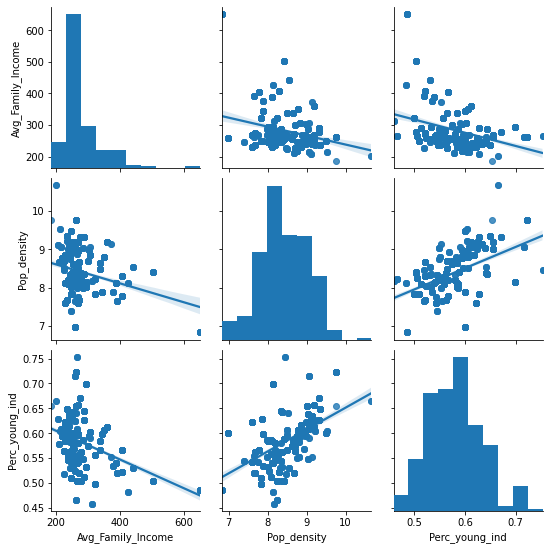

In [40]:
features = main_table[['Avg_Family_Income','Pop_density','Perc_young_ind']]
g = sns.pairplot(features,kind="reg")


In [32]:
n = len(features.columns)

pca = PCA(n_components = n)
# defaults number of PCs to number of columns in imported data (ie number of
# features), but can be set to any integer less than or equal to that value

pca.fit(features)



## project data into PC space

# 0,1 denote PC1 and PC2; change values for other PCs
xvector = pca.components_[0] # see 'prcomp(my_data)$rotation' in R
yvector = pca.components_[1]

xs = pca.transform(dat)[:,0] # see 'prcomp(my_data)$x' in R
ys = pca.transform(dat)[:,1]




## visualize projections
    
## Note: scale values for arrows and text are a bit inelegant as of now,
##       so feel free to play around with them

for i in range(len(xvector)):
# arrows project features (ie columns from csv) as vectors onto PC axes
    plt.arrow(0, 0, xvector[i]*max(xs), yvector[i]*max(ys),
              color='r', width=0.0005, head_width=0.0025)
    plt.text(xvector[i]*max(xs)*1.2, yvector[i]*max(ys)*1.2,
             list(dat.columns.values)[i], color='r')

for i in range(len(xs)):
# circles project documents (ie rows from csv) as points onto PC axes
    plt.plot(xs[i], ys[i], 'bo')
    plt.text(xs[i]*1.2, ys[i]*1.2, list(dat.index)[i], color='b')

plt.show()

0     -0.279246
1     -0.253314
2     -0.218103
3      1.305227
4     -1.216309
         ...   
878   -1.219086
879   -1.219086
880   -0.410250
881   -0.569961
882   -0.452385
Name: principal component 2, Length: 883, dtype: float64